## So sánh các phương pháp Over-sampling 

Chúng ta sẽ xác định xem liệu các thuật toán oversampling mà chúng ta đã học có cải thiện chất lượng của Random Forest trên các tập dữ liệu khác nhau với các lớp mất cân bằng không.

In [1]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from imblearn.datasets import fetch_datasets

from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE,
    ADASYN,
    BorderlineSMOTE,
    SVMSMOTE,
)

In [2]:
oversampler_dict = {

    'random': RandomOverSampler(
        sampling_strategy='auto',
        random_state=0),

    'smote': SMOTE(
        sampling_strategy='auto',  # chỉ lấy mẫu lớp thiểu số
        random_state=0,  # khả năng tái lặp
        k_neighbors=5,
        n_jobs=None),

    'adasyn': ADASYN(
        sampling_strategy='auto',  # chỉ lấy mẫu lớp thiểu số
        random_state=0,  # khả năng tái lặp
        n_neighbors=5,
        n_jobs=None),

    'border1': BorderlineSMOTE(
        sampling_strategy='auto',  # chỉ lấy mẫu lớp thiểu số
        random_state=0,  # khả năng tái lặp
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-1',
        n_jobs=None),

    'border2': BorderlineSMOTE(
        sampling_strategy='auto',  # chỉ lấy mẫu lớp thiểu số
        random_state=0,  # khả năng tái lặp
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-2',
        n_jobs=None),

    'svm': SVMSMOTE(
        sampling_strategy='auto',  # chỉ lấy mẫu lớp thiểu số
        random_state=0,  # khả năng tái lặp
        k_neighbors=5,
        m_neighbors=10,
        n_jobs=None,
        svm_estimator=SVC(kernel='linear')),
}

In [3]:
datasets_ls = [
    'car_eval_34',
    'ecoli',
    # 'thyroid_sick',
    # 'arrhythmia',
    # 'ozone_level'
]

In [4]:
# in ra mất cân bằng lớp
## Yêu cầu 1:
## VIẾT CODE Ở ĐÂY:
for dataset in datasets_ls:
    data = fetch_datasets()[dataset]
    print(dataset)
    print(Counter(data.target))
    print()

car_eval_34
Counter({-1: 1594, 1: 134})

ecoli
Counter({-1: 301, 1: 35})



<details><summary> Gợi ý </summary>

Sử dụng ```dataset```

</details>

In [5]:
# hàm huấn luyện random forest và đánh giá chất lượng

def run_randomForests(X_train, X_test, y_train, y_test):

    rf = RandomForestClassifier(
        n_estimators=100, random_state=39, max_depth=2, n_jobs=4)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:, 1])))

    print('Test set')
    pred = rf.predict_proba(X_test)
    print(
        'Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:, 1])))

    return roc_auc_score(y_test, pred[:, 1])

In [6]:
# lưu kết quả
results_dict = {}
shapes_dict = {}

## Yêu cầu 2:
## VIẾT CODE Ở ĐÂY:

for dataset in datasets_ls:
    
    results_dict[dataset] = {}
    shapes_dict[dataset] = {}
    
    print(dataset)
    
    # load tập dữ liệu
    data = fetch_datasets()[dataset]
    
    # tách thành tập huấn luyện và tập kiểm tra
    X_train, X_test, y_train, y_test = train_test_split(
    data.data,  
    data.target, 
    test_size=0.3,
    random_state=0)
    
    # do một số kỹ thuật oversampling sử dụng KNN
    # chúng ta thiết lập các biến ở cùng một tỷ lệ
    scaler = MinMaxScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
        
    roc = run_randomForests(X_train, X_test, y_train, y_test)
    
    # lưu trữ kết quả
    results_dict[dataset]['full_data'] = roc
    shapes_dict[dataset]['full_data'] = len(X_train)
    
    print()
    
    for oversampler in oversampler_dict.keys():
        
        print(oversampler)
        
        # lấy lại mẫu
        X_resampled, y_resampled = oversampler_dict[oversampler].fit_resample(X_train, y_train)
        
        # đánh giá chất lượng
        roc = run_randomForests(X_resampled, X_test, y_resampled, y_test)
        
        # lưu trữ kết quả
        results_dict[dataset][oversampler] = roc
        shapes_dict[dataset][oversampler] = len(X_resampled)
        print()
        
    print()
        

car_eval_34
Train set
Random Forests roc-auc: 0.9581261802905924
Test set
Random Forests roc-auc: 0.9440504133074803

random
Train set
Random Forests roc-auc: 0.9867662928276872
Test set
Random Forests roc-auc: 0.9847688539646903

smote
Train set
Random Forests roc-auc: 0.9898270191801236
Test set
Random Forests roc-auc: 0.9777018063067661

adasyn
Train set
Random Forests roc-auc: 0.9895635910626338
Test set
Random Forests roc-auc: 0.9845392386978264

border1
Train set
Random Forests roc-auc: 0.9889084801068846
Test set
Random Forests roc-auc: 0.9839524441269516

border2
Train set
Random Forests roc-auc: 0.9906154854125718
Test set
Random Forests roc-auc: 0.9855342381875702

svm
Train set
Random Forests roc-auc: 0.9868208913040686
Test set
Random Forests roc-auc: 0.9754056536381264


ecoli
Train set
Random Forests roc-auc: 0.9716599190283401
Test set
Random Forests roc-auc: 0.9408212560386474

random
Train set
Random Forests roc-auc: 0.9687507154140244
Test set
Random Forests roc-auc: 

<details><summary> Gợi ý </summary>

Sử dụng ```dataset``` và ```oversampler```

</details>

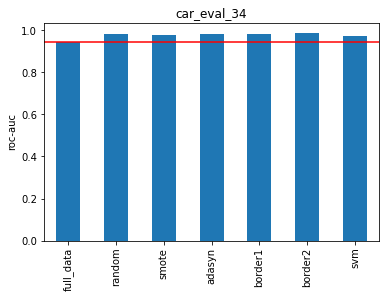

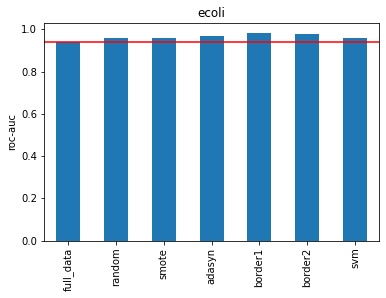

In [7]:
for dataset in datasets_ls:
    ## Yêu cầu 3:
    ## VIẾT CODE Ở ĐÂY:
    pd.Series(results_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('roc-auc')
#     plt.ylim(0.55, 0.9)
    plt.axhline(results_dict[dataset]['full_data'], color='r')
    plt.show()

<details><summary> Gợi ý </summary>

Sử dụng ```bar()``` để vẽ biểu đồ rồi sử dụng ```axhline()```

</details>

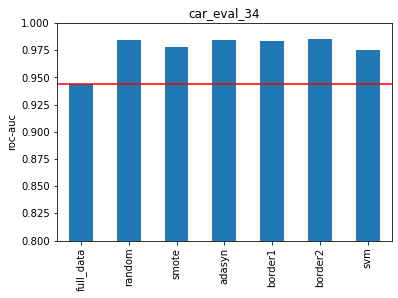

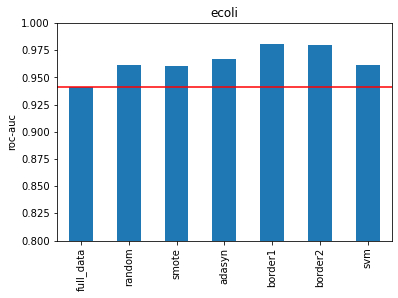

In [8]:
for dataset in datasets_ls:
    ## Yêu cầu 4:
    ## VIẾT CODE Ở ĐÂY:
    pd.Series(results_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('roc-auc')
    plt.ylim(0.8, 1)
    plt.axhline(results_dict[dataset]['full_data'], color='r')
    plt.show()

**Các kỹ thuật oversampling hoạt động tốt hơn trên các tập dữ liệu khác nhau.** 

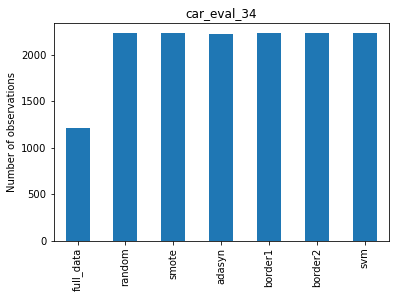

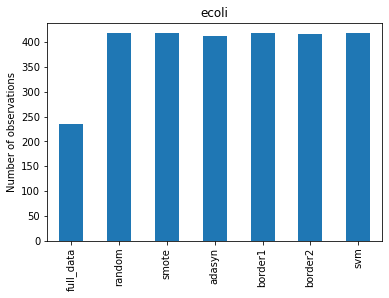

In [9]:
for dataset in datasets_ls:
    
    pd.Series(shapes_dict[dataset]).plot.bar()
    plt.title(dataset)
    plt.ylabel('Number of observations')
    plt.show()